# Diffusion Model Project

In [5]:
from functions import *

In [6]:
import torch
import diffusers
from PIL import Image
from tqdm import tqdm
import os

/Users/noahbrandt/Documents/Programmierung/Python/Studium/Understanding Deep Learning/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/noahbrandt/Documents/Programmierung/Python/Studium/Understanding Deep Learning/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# setup
model_id = "google/ddpm-bedroom-256" # "google/ddpm-celebahq-256"
model = diffusers.UNet2DModel.from_pretrained(model_id)
scheduler = diffusers.DDPMScheduler.from_pretrained(model_id)
scheduler.set_timesteps(50)

An error occurred while trying to fetch google/ddpm-bedroom-256: google/ddpm-bedroom-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


# Denoising Animation

In [14]:
# input prepraration
image_size = model.config.sample_size # get image size
noise = torch.randn((1, 3, image_size, image_size)) # sample random noise

,,
Image,Predicted Noise,Image - Predicted Noise
,49/50,

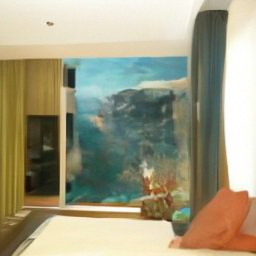
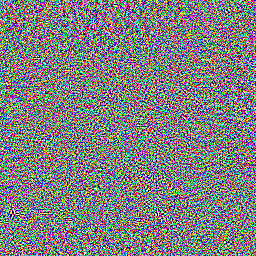
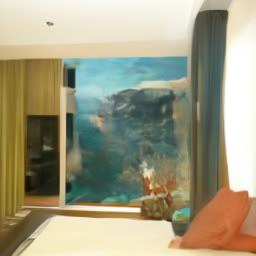

In [15]:
# output generation
current = noise
history = [noise]
for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        predicted_noise = model(current, t).sample
        current = scheduler.step(predicted_noise, t, current).prev_sample
        show_table([[tensor_as_html(history[-1]), tensor_as_html(predicted_noise), tensor_as_html(current)], ["Image", "Predicted Noise", "Image - Predicted Noise"], ["", f"{i}/50", ""]])
        history.append(current)

,,,,,,

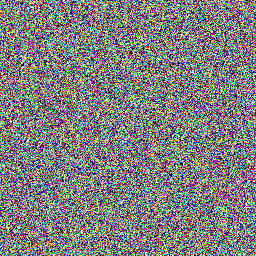
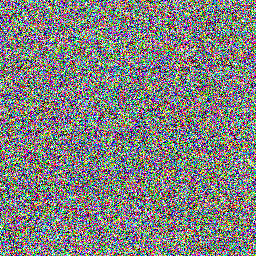
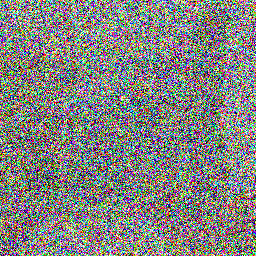
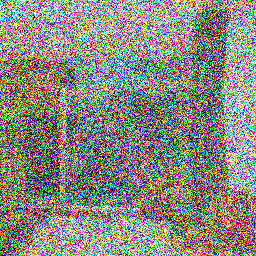
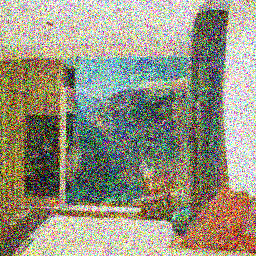
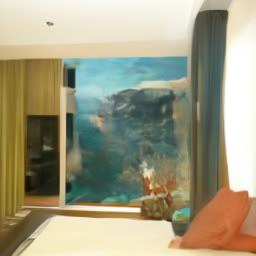
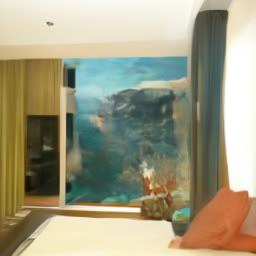

In [ ]:
# show images
show_images(*history[::10], history[-1])

In [17]:
# save image
os.makedirs("output", exist_ok=True)
tensor_as_image(current).save("../output/output.png")

# Forward and Backward Process

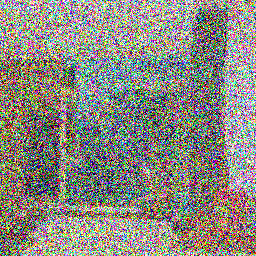

In [ ]:
# forward process
noised_image = scheduler.add_noise(current, noise, scheduler.timesteps[30])
tensor_as_image(noised_image)

""

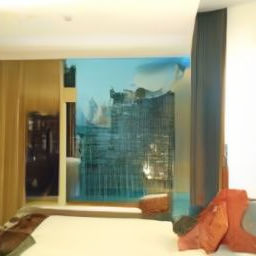

100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


In [23]:
# backward process
current = noised_image
for t in tqdm(scheduler.timesteps[30:]):
    with torch.no_grad():
        predicted_noise = model(current, t).sample
        current = scheduler.step(predicted_noise, t, current).prev_sample
        show_images(current)

,,

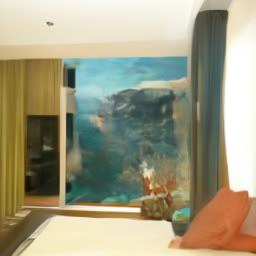
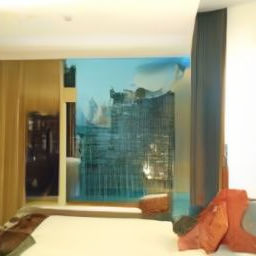
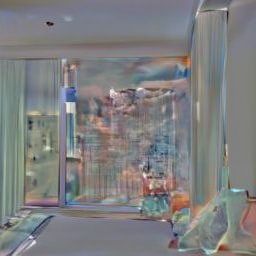

In [25]:
# compare images
show_images(history[-1], current, history[-1] - current)

In [ ]:
# create forward / backward process image
image = current # image_as_tensor(Image.open("../output/ddpm_9.png"))

# setup output image
output = Image.new("RGB", (image_size * 50, image_size * 50), (255, 255, 255))
output.paste(tensor_as_image(image), (0, 0))

# output generation
tqdm_bar = tqdm(total=sum(range(1, 51)))
for i in reversed(range(50)):
    current = scheduler.add_noise(image, noise, scheduler.timesteps[i])
    output.paste(tensor_as_image(current), (0, image_size * (50 - i)))
    for j, t in enumerate(scheduler.timesteps[i:]):
        with torch.no_grad():
            predicted_noise = model(current, t).sample
            current = scheduler.step(predicted_noise, t, current).prev_sample
            output.paste(tensor_as_image(current), (image_size * (j + 1), image_size * (50 - i)))
        tqdm_bar.update(1)

# save output image
output.save("output/process.png")

  0%|          | 4/1275 [00:11<58:16,  2.75s/it]  

KeyboardInterrupt: 